In [171]:
import pandas as pd
import numpy as np
import string
import gensim
import matplotlib.pyplot as plt
import re  
import nltk
plt.style.use('ggplot')

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
import pyLDAvis
import pyLDAvis.gensim
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

TOKEN_PATTERN_rus = "[а-яё]+"
from nltk.corpus import stopwords
stop_words = set(stopwords.words("russian"))

In [324]:
df1 = pd.read_csv('kp_all_parts_1-9.csv')
df2 = pd.read_csv('kp_all_part_10.csv')
df3 = pd.read_csv('kp_all_part_11.csv')
df4 = pd.read_csv('kp_all_part_12.csv')
df5 = pd.read_csv('kp_all_part_13.csv')
df6 = pd.read_csv('kp_all_part_14.csv')
df1.drop("Unnamed: 0", axis = 1, inplace=True)

In [325]:
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index= True)

In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493757 entries, 0 to 493756
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   filmId                      493757 non-null  int64  
 1   nameRu                      493755 non-null  object 
 2   nameEn                      169985 non-null  object 
 3   webUrl                      493757 non-null  object 
 4   year                        476420 non-null  float64
 5   filmLength                  344636 non-null  object 
 6   slogan                      83166 non-null   object 
 7   description                 106427 non-null  object 
 8   type                        493757 non-null  object 
 9   ratingAgeLimits             60139 non-null   float64
 10  premiereRu                  8952 non-null    object 
 11  distributors                6453 non-null    object 
 12  premiereWorld               329890 non-null  object 
 13  premiereDigita

In [327]:
df.drop(["filmId", "webUrl", "type", "premiereRu", "distributors", "premiereDigital", "ratingVoteCount", "premiereWorld", "ratingFilmCritics", "ratingFilmCriticsVoteCount", "premiereWorldCountry"], axis = 1, inplace=True)

In [328]:
df.drop(["premiereWorldCountry"], axis = 1, inplace=True)

,nameRu,nameEn,year,filmLength,slogan,description,ratingAgeLimits,countries,genres,rating,ratingImdb,ratingImdbVoteCount,budget,actors,directors,producers,writers,operators
0,Люди Икс 2,X2,2003.0,2:14,"Сплотиться сегодня, чтобы наступило завтра","Мутанты продолжают борьбу против общества, кот...",12.0,"[{'country': 'Канада'}, {'country': 'США'}]","[{'genre': 'боевик'}, {'genre': 'триллер'}, {'...",7.6,7.4,505311,$110 000 000,"[8214, 8213, 8215, 1179, 8216, 6577, 7228, 821...",[8210],"[11274, 8212, 8210, 31424, 26945]","[8285, 8288, 8281, 8211, 31461, 8283, 31462, 8...",[307904]
1,Матрица: Перезагрузка,The Matrix Reloaded,2003.0,2:18,"Одни машины помогают нам жить, другие – пытают...","Борцы за свободу Нео, Тринити и Морфеус продол...",16.0,[{'country': 'США'}],"[{'genre': 'боевик'}, {'genre': 'фантастика'}]",7.7,7.2,507372,$150 000 000,"[7836, 9838, 1491, 6226, 520, 23331, 12193, 27...","[23330, 23329]","[23329, 23330]","[1790, 712, 1486300, 31351, 8525, 675690, 3140...",[278101]
2,Лиззи Магуайр,The Lizzie McGuire Movie,2003.0,1:34,Lizze McGuire goes to Rome.,Тринадцатилетняя школьница Лиззи Магуайер и ее...,12.0,[{'country': 'США'}],"[{'genre': 'комедия'}, {'genre': 'мелодрама'},...",6.3,5.5,35239,$17 000 000,"[31505, 31506, 1199020, 27255, 8781, 31508, 31...",[31501],"[31502, 31503, 31504, 31536]","[31538, 31502, 404151, 1122338, 1667153, 31536...",[284350]
3,Матрица,The Matrix,1999.0,2:16,Добро пожаловать в реальный мир,Жизнь Томаса Андерсона разделена на две части:...,16.0,[{'country': 'США'}],"[{'genre': 'боевик'}, {'genre': 'фантастика'}]",8.5,8.7,1639188,$63 000 000,"[7836, 9838, 6226, 1491, 23331, 9030, 23332, 2...","[23330, 23329]","[23329, 23330]","[1790, 712, 1787, 23359, 8525, 23360, 23361, 9...",[278101]
4,Клад,Holes,2003.0,1:57,"Кто ищет, тот всегда найдёт",Стэнли арестован по ложному обвинению в краже ...,12.0,[{'country': 'США'}],"[{'genre': 'детектив'}, {'genre': 'драма'}, {'...",7.3,7.0,76131,$20 000 000,"[6915, 515, 7628, 30162, 10087, 7666, 25307, 1...",[31623],[31624],"[31666, 31623, 6314, 31668, 7306, 3158885, 261...",[608570]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493752,Analiens,NaN,2014.0,0:10,NaN,NaN,NaN,[{'country': 'Испания'}],"[{'genre': 'короткометражка'}, {'genre': 'фант...",0.0,0.0,0,€2 000,"[1207069, 1208094, 459157, 4185791, 4185792, 4...",[3781794],[3781794],"[4185797, 3781794, 3781795]",[3781796]
493753,Оттрахать босса 3,Bangin' the Boss 3,2014.0,1:50,NaN,NaN,18.0,[{'country': 'США'}],[{'genre': 'для взрослых'}],0.0,0.0,0,NaN,"[2256024, 3731645, 1245476, 1349120, 1245183, ...",[228272],[],[],[]
493754,Manny and the Bell,NaN,2015.0,0:03,NaN,NaN,NaN,[{'country': 'США'}],"[{'genre': 'комедия'}, {'genre': 'короткометра...",0.0,0.0,0,$2 000,"[972646, 1711497, 4185799, 4185800]",[4185798],[4149456],[4149456],[2951081]
493755,Lita på mig,NaN,2017.0,0:25,NaN,NaN,NaN,[{'country': 'Швеция'}],"[{'genre': 'драма'}, {'genre': 'короткометражк...",0.0,0.0,0,SEK 50 000,"[4305982, 3856620, 4305984, 4305985, 4553757]",[2462810],[2462810],[2462810],[2559032]


In [329]:
i = 0
filmLength = []

for el in df.filmLength:
    if isinstance(el, str):
        try:
            h, m = el.split(":")
            h = int(h)
            m = int(m)
            filmLength.append(h*60+m)
        except TypeError:
            filmLength.append(0)
    else:
        filmLength.append(0)

In [330]:
df.filmLength = filmLength

In [331]:
#перевёл время в минуты

In [332]:
countries = []
for el in df.countries:
    try:
        strani = []
        c = el.split(",")
        for i in c:
            a, b = i.split(":")
            b = b[2:-2]
            if "'" in b:
                b = b[:-1]
            strani.append(b)
        countries.append(strani)
    except ValueError:
        countries.append('0')

In [333]:
df.countries = countries

In [334]:
genres = []
for el in df.genres:
    try:
        genre = []
        c = el.split(",")
        for i in c:
            a, b = i.split(":")
            b = b[2:-2]
            if "'" in b:
                b = b[:-1]
            genre.append(b)
        genres.append(genre)
    except ValueError:
        genres.append('0')

In [335]:
df.genres = genres

In [336]:
def isNaN(num):
    return num != num

In [337]:
ratingAgeLimits = []
for el in df.ratingAgeLimits:
    if isNaN(el):
        ratingAgeLimits.append(0)
    else:
        ratingAgeLimits.append(el)

In [338]:
df.ratingAgeLimits = ratingAgeLimits

In [340]:
df.drop(["slogan", "ratingImdb", "ratingImdbVoteCount", "budget"], axis = 1, inplace=True)

In [344]:
df

,nameRu,nameEn,year,filmLength,description,ratingAgeLimits,countries,genres,rating,actors,directors,producers,writers,operators
0,Люди Икс 2,X2,2003,134,"Мутанты продолжают борьбу против общества, кот...",12.0,"[Канада, США]","[боевик, триллер, фантастика]",7.6,"[8214, 8213, 8215, 1179, 8216, 6577, 7228, 821...",[8210],"[11274, 8212, 8210, 31424, 26945]","[8285, 8288, 8281, 8211, 31461, 8283, 31462, 8...",[307904]
1,Матрица: Перезагрузка,The Matrix Reloaded,2003,138,"Борцы за свободу Нео, Тринити и Морфеус продол...",16.0,[США],"[боевик, фантастика]",7.7,"[7836, 9838, 1491, 6226, 520, 23331, 12193, 27...","[23330, 23329]","[23329, 23330]","[1790, 712, 1486300, 31351, 8525, 675690, 3140...",[278101]
2,Лиззи Магуайр,The Lizzie McGuire Movie,2003,94,Тринадцатилетняя школьница Лиззи Магуайер и ее...,12.0,[США],"[комедия, мелодрама, приключения]",6.3,"[31505, 31506, 1199020, 27255, 8781, 31508, 31...",[31501],"[31502, 31503, 31504, 31536]","[31538, 31502, 404151, 1122338, 1667153, 31536...",[284350]
3,Матрица,The Matrix,1999,136,Жизнь Томаса Андерсона разделена на две части:...,16.0,[США],"[боевик, фантастика]",8.5,"[7836, 9838, 6226, 1491, 23331, 9030, 23332, 2...","[23330, 23329]","[23329, 23330]","[1790, 712, 1787, 23359, 8525, 23360, 23361, 9...",[278101]
4,Клад,Holes,2003,117,Стэнли арестован по ложному обвинению в краже ...,12.0,[США],"[детектив, драма, комедия]",7.3,"[6915, 515, 7628, 30162, 10087, 7666, 25307, 1...",[31623],[31624],"[31666, 31623, 6314, 31668, 7306, 3158885, 261...",[608570]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493752,Analiens,NaN,2014,10,NaN,0.0,[Испания],"[короткометражка, фантастика]",0.0,"[1207069, 1208094, 459157, 4185791, 4185792, 4...",[3781794],[3781794],"[4185797, 3781794, 3781795]",[3781796]
493753,Оттрахать босса 3,Bangin' the Boss 3,2014,110,NaN,18.0,[США],[для взрослых],0.0,"[2256024, 3731645, 1245476, 1349120, 1245183, ...",[228272],[],[],[]
493754,Manny and the Bell,NaN,2015,3,NaN,0.0,[США],"[комедия, короткометражка]",0.0,"[972646, 1711497, 4185799, 4185800]",[4185798],[4149456],[4149456],[2951081]
493755,Lita på mig,NaN,2017,25,NaN,0.0,[Швеция],"[драма, короткометражка]",0.0,"[4305982, 3856620, 4305984, 4305985, 4553757]",[2462810],[2462810],[2462810],[2559032]


In [116]:
actors = []
for a in df.actors:
    try:
        act = []
        c = a.split(",")
        for i in c:
            if '[' in i:
                i = i[1:]
            if ']' in i:
                i = i[:-1]
            act.append(i)
        actors.append(act)
    except AttributeError:
        actors.append('0')

In [117]:
df.actors = actors

In [118]:
directors = []
for a in df.directors:
    try:
        dir1 = []
        c = a.split(",")
        for i in c:
            if '[' in i:
                i = i[1:]
            if ']' in i:
                i = i[:-1]
            dir1.append(i)
        directors.append(dir1)
    except AttributeError:
        directors.append('0')
        
df.directors = directors

In [119]:
producers = []
for a in df.producers:
    try:
        prod = []
        c = a.split(",")
        for i in c:
            if '[' in i:
                i = i[1:]
            if ']' in i:
                i = i[:-1]
            prod.append(i)
        producers.append(prod)
    except AttributeError:
        producers.append('0')
        
df.producers = producers

In [120]:
writers = []
for a in df.writers:
    try:
        wr = []
        c = a.split(",")
        for i in c:
            if '[' in i:
                i = i[1:]
            if ']' in i:
                i = i[:-1]
            wr.append(i)
        writers.append(wr)
    except AttributeError:
        writers.append('0')
        
df.writers = writers

In [121]:
operators = []
for a in df.operators:
    try:
        op = []
        c = a.split(",")
        for i in c:
            if '[' in i:
                i = i[1:]
            if ']' in i:
                i = i[:-1]
            op.append(i)
        operators.append(op)
    except AttributeError:
        operators.append('0')
        
df.operators = operators

In [342]:
year = []
for a in df.year:
    try:
        year.append(int(a))
    except ValueError:
        year.append('0')

In [343]:
df.year = year

In [124]:
#df.to_csv('DataFrame.csv')

In [125]:
#df = pd.read_csv('DataFrame.csv', index_col= False)
#df.drop("Unnamed: 0", axis = 1, inplace=True)

In [126]:
df = df.loc[isNaN(df['description']) == False]

In [215]:
df.shape

(106427, 17)

In [139]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [151]:
words = df.loc[0].description
words = words.split(' ')

In [197]:
description = []

In [200]:
for el in tqdm_notebook(df.description):
    w = []
    words = el
    words = words.split(' ')
    for word in words:
        word = re.sub('[^A-zА-яЁе]+','',  word)
        p = morph.parse(word)[0]
        if p.normal_form not in stop_words: 
            w.append(p.normal_form)
    description.append(w)

In [202]:
d = description

In [208]:
description = description[1:]

In [209]:
len(description)

106427

In [217]:
df.shape

(106427, 17)

In [212]:
len(description)

106427

In [213]:
df

,nameRu,nameEn,year,filmLength,slogan,description,ratingAgeLimits,countries,genres,ratingImdb,ratingImdbVoteCount,budget,actors,directors,producers,writers,operators
0,Люди Икс 2,X2,2003,134,"Сплотиться сегодня, чтобы наступило завтра","Мутанты продолжают борьбу против общества, кот...",12.0,"[Канада, США]","[боевик, триллер, фантастика]",7.4,505311,$110 000 000,"[8214, 8213, 8215, 1179, 8216, 6577, 722...",[8210],"[11274, 8212, 8210, 31424, 26945]","[8285, 8288, 8281, 8211, 31461, 8283, 31...",[307904]
1,Матрица: Перезагрузка,The Matrix Reloaded,2003,138,"Одни машины помогают нам жить, другие – пытают...","Борцы за свободу Нео, Тринити и Морфеус продол...",16.0,[США],"[боевик, фантастика]",7.2,507372,$150 000 000,"[7836, 9838, 1491, 6226, 520, 23331, 121...","[23330, 23329]","[23329, 23330]","[1790, 712, 1486300, 31351, 8525, 675690,...",[278101]
2,Лиззи Магуайр,The Lizzie McGuire Movie,2003,94,Lizze McGuire goes to Rome.,Тринадцатилетняя школьница Лиззи Магуайер и ее...,12.0,[США],"[комедия, мелодрама, приключения]",5.5,35239,$17 000 000,"[31505, 31506, 1199020, 27255, 8781, 3150...",[31501],"[31502, 31503, 31504, 31536]","[31538, 31502, 404151, 1122338, 1667153, ...",[284350]
3,Матрица,The Matrix,1999,136,Добро пожаловать в реальный мир,Жизнь Томаса Андерсона разделена на две части:...,16.0,[США],"[боевик, фантастика]",8.7,1639188,$63 000 000,"[7836, 9838, 6226, 1491, 23331, 9030, 23...","[23330, 23329]","[23329, 23330]","[1790, 712, 1787, 23359, 8525, 23360, 23...",[278101]
4,Клад,Holes,2003,117,"Кто ищет, тот всегда найдёт",Стэнли арестован по ложному обвинению в краже ...,12.0,[США],"[детектив, драма, комедия]",7.0,76131,$20 000 000,"[6915, 515, 7628, 30162, 10087, 7666, 25...",[31623],[31624],"[31666, 31623, 6314, 31668, 7306, 3158885...",[608570]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493659,Любовь всей моей жизни,Love of My Life,2017,106,NaN,Рядовое посещение клиники переворачивает будни...,0.0,[Канада],"[драма, комедия]",5.2,328,NaN,"[3792, 13173, 14494, 14995, 3122213, 1960...",[264205],[264205],"[251645, 25631, 2277202, 3084734, 545078, ...",[612816]
493661,Американская басня,American Fable,2016,96,NaN,"Средний Запад, 80-е годы. 11-летняя Гитти узна...",16.0,[США],[триллер],5.9,3213,NaN,"[2869241, 6482, 10139, 1744241, 2388047, ...",[2651428],[2651428],"[2651428, 1869957, 5654731, 2238329, 22399...",[1329819]
493679,Перерождение,Rebirth,2016,100,NaN,"Офисному работнику и отцу Кайлу, наносит неожи...",0.0,[США],[триллер],5.0,4312,NaN,"[32454, 3832, 1377256, 1131824, 1214182, ...",[1967679],[1967679],"[732081, 380463, 2814404, 1633472]",[1517338]
493696,Большой брат следит за тобой,NaN,2015,54,NaN,"Следить, оставаясь незамеченным - вот суть нег...",0.0,[Россия],[документальный],0.0,0,NaN,0,0,0,0,0


In [216]:
df

,nameRu,nameEn,year,filmLength,slogan,description,ratingAgeLimits,countries,genres,ratingImdb,ratingImdbVoteCount,budget,actors,directors,producers,writers,operators
0,Люди Икс 2,X2,2003,134,"Сплотиться сегодня, чтобы наступило завтра","Мутанты продолжают борьбу против общества, кот...",12.0,"[Канада, США]","[боевик, триллер, фантастика]",7.4,505311,$110 000 000,"[8214, 8213, 8215, 1179, 8216, 6577, 722...",[8210],"[11274, 8212, 8210, 31424, 26945]","[8285, 8288, 8281, 8211, 31461, 8283, 31...",[307904]
1,Матрица: Перезагрузка,The Matrix Reloaded,2003,138,"Одни машины помогают нам жить, другие – пытают...","Борцы за свободу Нео, Тринити и Морфеус продол...",16.0,[США],"[боевик, фантастика]",7.2,507372,$150 000 000,"[7836, 9838, 1491, 6226, 520, 23331, 121...","[23330, 23329]","[23329, 23330]","[1790, 712, 1486300, 31351, 8525, 675690,...",[278101]
2,Лиззи Магуайр,The Lizzie McGuire Movie,2003,94,Lizze McGuire goes to Rome.,Тринадцатилетняя школьница Лиззи Магуайер и ее...,12.0,[США],"[комедия, мелодрама, приключения]",5.5,35239,$17 000 000,"[31505, 31506, 1199020, 27255, 8781, 3150...",[31501],"[31502, 31503, 31504, 31536]","[31538, 31502, 404151, 1122338, 1667153, ...",[284350]
3,Матрица,The Matrix,1999,136,Добро пожаловать в реальный мир,Жизнь Томаса Андерсона разделена на две части:...,16.0,[США],"[боевик, фантастика]",8.7,1639188,$63 000 000,"[7836, 9838, 6226, 1491, 23331, 9030, 23...","[23330, 23329]","[23329, 23330]","[1790, 712, 1787, 23359, 8525, 23360, 23...",[278101]
4,Клад,Holes,2003,117,"Кто ищет, тот всегда найдёт",Стэнли арестован по ложному обвинению в краже ...,12.0,[США],"[детектив, драма, комедия]",7.0,76131,$20 000 000,"[6915, 515, 7628, 30162, 10087, 7666, 25...",[31623],[31624],"[31666, 31623, 6314, 31668, 7306, 3158885...",[608570]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493659,Любовь всей моей жизни,Love of My Life,2017,106,NaN,Рядовое посещение клиники переворачивает будни...,0.0,[Канада],"[драма, комедия]",5.2,328,NaN,"[3792, 13173, 14494, 14995, 3122213, 1960...",[264205],[264205],"[251645, 25631, 2277202, 3084734, 545078, ...",[612816]
493661,Американская басня,American Fable,2016,96,NaN,"Средний Запад, 80-е годы. 11-летняя Гитти узна...",16.0,[США],[триллер],5.9,3213,NaN,"[2869241, 6482, 10139, 1744241, 2388047, ...",[2651428],[2651428],"[2651428, 1869957, 5654731, 2238329, 22399...",[1329819]
493679,Перерождение,Rebirth,2016,100,NaN,"Офисному работнику и отцу Кайлу, наносит неожи...",0.0,[США],[триллер],5.0,4312,NaN,"[32454, 3832, 1377256, 1131824, 1214182, ...",[1967679],[1967679],"[732081, 380463, 2814404, 1633472]",[1517338]
493696,Большой брат следит за тобой,NaN,2015,54,NaN,"Следить, оставаясь незамеченным - вот суть нег...",0.0,[Россия],[документальный],0.0,0,NaN,0,0,0,0,0


<AxesSubplot:xlabel='filmLength', ylabel='ratingImdb'>

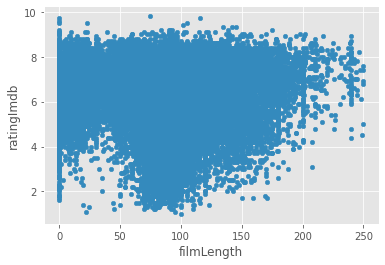

In [233]:
d.plot(x='filmLength', y='ratingImdb', kind='scatter')

In [226]:
d = df.loc[df['filmLength'] <= 250]

In [230]:
d.shape

(92152, 17)

In [229]:
d = d.loc[d['ratingImdb'] != 0]

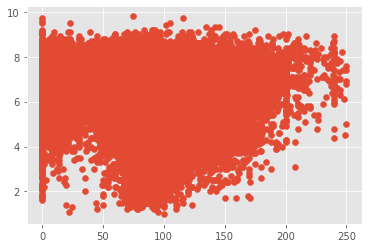

In [357]:
fig, ax = plt.subplots()

#ax.bar(cc[:200], d['ratingImdb'][:200])
plt.scatter(d.filmLength, d['ratingImdb'])
'''
fig.set_figheight(6)
fig.set_figwidth(30)
ax.set_xlabel('Страна')
ax.set_ylabel('Рейнтинг IMDb')
'''
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

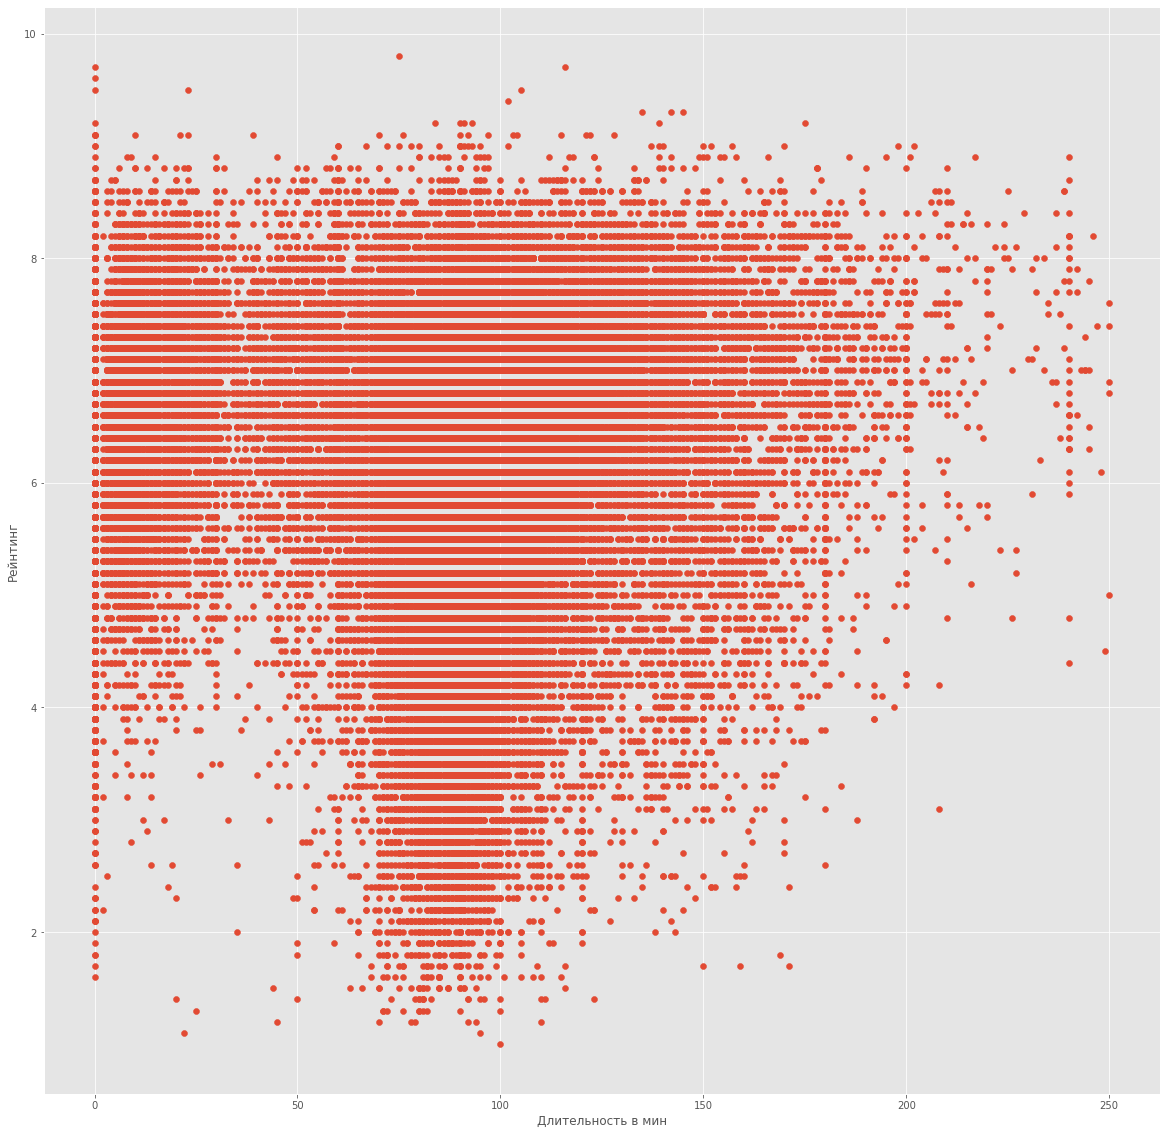

In [362]:
fig, ax = plt.subplots()
ax.scatter(d.filmLength, d['ratingImdb'])
ax.set_xlabel('Длительность в мин')
ax.set_ylabel('Рейнтинг')
fig.set_figwidth(20)
fig.set_figheight(20) 
plt.show

In [346]:
cc = []
for el in d.countries:
    if el[0] == '':
        pass
    else:
        cc.append(el[0])

In [317]:
d = d.loc[d.genres[0] != 0]

KeyError: True

In [307]:
d.shape

(92152, 17)

In [309]:
d.shape

(92152, 17)

In [319]:
len(cc)

91657

In [323]:
df.drop(['slogan'])

,nameRu,nameEn,year,filmLength,slogan,description,ratingAgeLimits,countries,genres,ratingImdb,ratingImdbVoteCount,budget,actors,directors,producers,writers,operators
0,Люди Икс 2,X2,2003,134,"Сплотиться сегодня, чтобы наступило завтра","Мутанты продолжают борьбу против общества, кот...",12.0,"[Канада, США]","[боевик, триллер, фантастика]",7.4,505311,$110 000 000,"[8214, 8213, 8215, 1179, 8216, 6577, 722...",[8210],"[11274, 8212, 8210, 31424, 26945]","[8285, 8288, 8281, 8211, 31461, 8283, 31...",[307904]
1,Матрица: Перезагрузка,The Matrix Reloaded,2003,138,"Одни машины помогают нам жить, другие – пытают...","Борцы за свободу Нео, Тринити и Морфеус продол...",16.0,[США],"[боевик, фантастика]",7.2,507372,$150 000 000,"[7836, 9838, 1491, 6226, 520, 23331, 121...","[23330, 23329]","[23329, 23330]","[1790, 712, 1486300, 31351, 8525, 675690,...",[278101]
2,Лиззи Магуайр,The Lizzie McGuire Movie,2003,94,Lizze McGuire goes to Rome.,Тринадцатилетняя школьница Лиззи Магуайер и ее...,12.0,[США],"[комедия, мелодрама, приключения]",5.5,35239,$17 000 000,"[31505, 31506, 1199020, 27255, 8781, 3150...",[31501],"[31502, 31503, 31504, 31536]","[31538, 31502, 404151, 1122338, 1667153, ...",[284350]
3,Матрица,The Matrix,1999,136,Добро пожаловать в реальный мир,Жизнь Томаса Андерсона разделена на две части:...,16.0,[США],"[боевик, фантастика]",8.7,1639188,$63 000 000,"[7836, 9838, 6226, 1491, 23331, 9030, 23...","[23330, 23329]","[23329, 23330]","[1790, 712, 1787, 23359, 8525, 23360, 23...",[278101]
4,Клад,Holes,2003,117,"Кто ищет, тот всегда найдёт",Стэнли арестован по ложному обвинению в краже ...,12.0,[США],"[детектив, драма, комедия]",7.0,76131,$20 000 000,"[6915, 515, 7628, 30162, 10087, 7666, 25...",[31623],[31624],"[31666, 31623, 6314, 31668, 7306, 3158885...",[608570]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493659,Любовь всей моей жизни,Love of My Life,2017,106,NaN,Рядовое посещение клиники переворачивает будни...,0.0,[Канада],"[драма, комедия]",5.2,328,NaN,"[3792, 13173, 14494, 14995, 3122213, 1960...",[264205],[264205],"[251645, 25631, 2277202, 3084734, 545078, ...",[612816]
493661,Американская басня,American Fable,2016,96,NaN,"Средний Запад, 80-е годы. 11-летняя Гитти узна...",16.0,[США],[триллер],5.9,3213,NaN,"[2869241, 6482, 10139, 1744241, 2388047, ...",[2651428],[2651428],"[2651428, 1869957, 5654731, 2238329, 22399...",[1329819]
493679,Перерождение,Rebirth,2016,100,NaN,"Офисному работнику и отцу Кайлу, наносит неожи...",0.0,[США],[триллер],5.0,4312,NaN,"[32454, 3832, 1377256, 1131824, 1214182, ...",[1967679],[1967679],"[732081, 380463, 2814404, 1633472]",[1517338]
493696,Большой брат следит за тобой,NaN,2015,54,NaN,"Следить, оставаясь незамеченным - вот суть нег...",0.0,[Россия],[документальный],0.0,0,NaN,0,0,0,0,0
